In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
train_ds.cardinality(), val_ds.cardinality(), test_ds.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=2936>,
 <tf.Tensor: shape=(), dtype=int64, numpy=367>,
 <tf.Tensor: shape=(), dtype=int64, numpy=367>)

In [4]:
class_names = metadata.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [5]:
def plot_figure(ds, aug=False, n_pictures=9):
  plt.figure(figsize=(5, 5))
  for idx, ds in enumerate(ds.take(n_pictures)):
      ax = plt.subplot(3, 3, idx + 1)
      if aug:
        img = data_augmentation(ds[0])
      else:
        img = ds[0]
      plt.imshow(img.numpy().astype("uint8"))
      plt.title(class_names[ds[1].numpy()])
      plt.axis("off")

In [6]:
for item, label in train_ds.take(1):
  print(item.shape)

(333, 500, 3)


In [7]:
for item, label in train_ds.take(1):
  print(item[0][0])

tf.Tensor([ 93 122  30], shape=(3,), dtype=uint8)


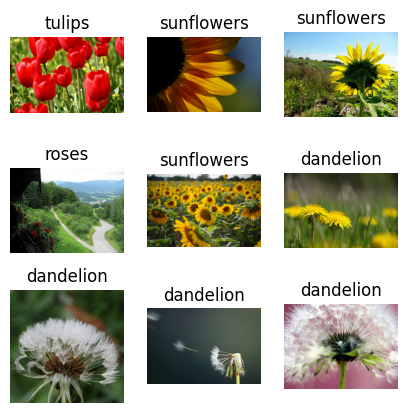

In [8]:
plot_figure(train_ds)

Resizing

In [9]:
resizer = tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True)
train_ds = train_ds.map(lambda x, y: (resizer(x), y))
val_ds = val_ds.map(lambda x, y: (resizer(x), y))
test_ds = test_ds.map(lambda x, y: (resizer(x), y))

In [10]:
for item, label in train_ds.take(1):
  print(item.shape)

(224, 224, 3)


Data augmentation -> we don't have a lot of data

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
  tf.keras.layers.RandomRotation(factor=20/360, seed=42, fill_mode="constant", fill_value=0),
  tf.keras.layers.RandomContrast(factor=0.2, seed=42),
  tf.keras.layers.RandomZoom(height_factor=0.15, seed=42, fill_mode="constant", fill_value=0)
])

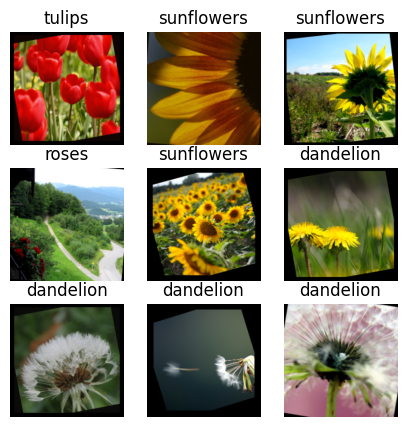

In [12]:
plot_figure(train_ds, aug=True)

Build model

In [13]:
DefaultConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=(3,3), activation="relu",
                        strides=(1,1), kernel_initializer="he_normal")

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42), # dit gedaan ipv data_augmentation toe te voegen omdat ik error kreeg, maar was hier niet door (was omdat ds niet gebatched was...)
    tf.keras.layers.RandomRotation(factor=20/360, seed=42, fill_mode="constant", fill_value=0),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    tf.keras.layers.RandomZoom(height_factor=0.15, seed=42, fill_mode="constant", fill_value=0),

    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=5, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 random_contrast_1 (RandomC  (None, 224, 224, 3)       0         
 ontrast)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)     

In [14]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [15]:
train_ds = train_ds.shuffle(1000, seed=42).batch(128).prefetch(1)
val_ds = val_ds.batch(128).prefetch(1)

In [16]:
escb = tf.keras.callbacks.EarlyStopping(patience=2, min_delta=0.001, restore_best_weights=True)
model.fit(train_ds, batch_size=128, epochs=10, validation_data=val_ds, callbacks=[escb])

Epoch 1/10
23/23 [==============================] - 116s 3s/step - loss: 5.9952 - accuracy: 0.2463 - val_loss: 1.5265 - val_accuracy: 0.3161
Epoch 2/10
23/23 [==============================] - 23s 956ms/step - loss: 1.5316 - accuracy: 0.2793 - val_loss: 1.2931 - val_accuracy: 0.4550
Epoch 3/10
23/23 [==============================] - 24s 1s/step - loss: 1.3436 - accuracy: 0.3937 - val_loss: 1.3018 - val_accuracy: 0.4605
Epoch 4/10
23/23 [==============================] - 25s 999ms/step - loss: 1.3057 - accuracy: 0.4578 - val_loss: 1.2632 - val_accuracy: 0.4768
Epoch 5/10
23/23 [==============================] - 24s 987ms/step - loss: 1.2372 - accuracy: 0.4918 - val_loss: 1.2218 - val_accuracy: 0.5123
Epoch 6/10
23/23 [==============================] - 26s 1s/step - loss: 1.1946 - accuracy: 0.5061 - val_loss: 1.2076 - val_accuracy: 0.4932
Epoch 7/10
23/23 [==============================] - 24s 992ms/step - loss: 1.1774 - accuracy: 0.5351 - val_loss: 1.3134 - val_accuracy: 0.4796
Epoch 8

In [17]:
escb = tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.0001, restore_best_weights=True)
model.fit(train_ds, batch_size=128, epochs=20, validation_data=val_ds, callbacks=[escb])

Epoch 1/20
23/23 [==============================] - 23s 955ms/step - loss: 1.1345 - accuracy: 0.5433 - val_loss: 1.0914 - val_accuracy: 0.5613
Epoch 2/20
23/23 [==============================] - 25s 1s/step - loss: 1.0590 - accuracy: 0.5838 - val_loss: 1.0711 - val_accuracy: 0.6022
Epoch 3/20
23/23 [==============================] - 24s 994ms/step - loss: 1.0281 - accuracy: 0.5933 - val_loss: 1.0613 - val_accuracy: 0.6104
Epoch 4/20
23/23 [==============================] - 24s 1s/step - loss: 0.9823 - accuracy: 0.6349 - val_loss: 1.0348 - val_accuracy: 0.6485
Epoch 5/20
23/23 [==============================] - 24s 1s/step - loss: 0.9504 - accuracy: 0.6287 - val_loss: 1.0441 - val_accuracy: 0.6131
Epoch 6/20
23/23 [==============================] - 24s 989ms/step - loss: 0.9683 - accuracy: 0.6356 - val_loss: 1.0543 - val_accuracy: 0.5804
Epoch 7/20
23/23 [==============================] - 23s 965ms/step - loss: 0.9224 - accuracy: 0.6550 - val_loss: 0.9636 - val_accuracy: 0.6431
Epoch 8/